In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix
import random
import os

# Input data files check
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Load Data
trainData = pd.read_csv('/kaggle/input/titanic-extended/train.csv')
testData = pd.read_csv('/kaggle/input/titanic-extended/test.csv')

# Drop wiki features
trainData.drop(columns=['Boarded','Body','Age_wiki','Name_wiki','WikiId','Class','Hometown','Destination'], axis=1, inplace=True)
testData.drop(columns=['Boarded','Body','Age_wiki','Name_wiki','WikiId','Class','Hometown','Destination'], axis=1, inplace=True)

# --- Preprocessing Functions ---

def processName(data):
    data['Title'] = data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col',
                                                 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    data['Title'] = data['Title'].replace('Mlle', 'Miss')
    data['Title'] = data['Title'].replace('Ms', 'Miss')
    data['Title'] = data['Title'].replace('Mme', 'Mrs')
    return data

def processAge(data):
    guess_ages = np.zeros((2,3))
    for i in range(0, 1):
        for j in range(0, 3):
            guess_df = data[(data['Sex'] == i) & (data['Pclass'] == j+1)]['Age'].dropna()
            age_guess = guess_df.median()
            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5

    for i in range(0, 2):
        for j in range(0, 3):
            data.loc[ (data.Age.isnull()) & (data.Sex == i) & (data.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    data['Age'] = data['Age'].astype(int)
    
    data.loc[ data['Age'] <= 16, 'Age'] = 0
    data.loc[(data['Age'] > 16) & (data['Age'] <= 32), 'Age'] = 1
    data.loc[(data['Age'] > 32) & (data['Age'] <= 48), 'Age'] = 2
    data.loc[(data['Age'] > 48) & (data['Age'] <= 64), 'Age'] = 3
    data.loc[ data['Age'] > 64, 'Age'] = 4
    
    return data

def processCabin(data):
    cabinList = data.Cabin.tolist()
    pclassList = data.Pclass.tolist()
    for i, val in enumerate(cabinList):
        if pd.isnull(val):
            if pclassList[i] == 3:
                cabinList[i] = random.randint(5,7)
            elif pclassList[i] == 2:
                cabinList[i] = random.randint(4,6)
            else:
                cabinList[i] = random.randint(0,3)
            continue
        if val.startswith("A"):
            cabinList[i] = 1
        elif val.startswith("B"):
            cabinList[i] = 2
        elif val.startswith("C"):
            cabinList[i] = 3
        elif val.startswith("D"):
            cabinList[i] = 4
        elif val.startswith("E"):
            cabinList[i] = 5
        elif val.startswith("F"):
            cabinList[i] = 6
        elif val.startswith("G"):
            cabinList[i] = 7
        else:
            cabinList[i] = 0
    data['CabinNo'] = cabinList
    return data

def processFare(data): 
    data.loc[ data['Fare'] <= 7.91, 'Fare'] = 0
    data.loc[(data['Fare'] > 7.91) & (data['Fare'] <= 14.454), 'Fare'] = 1
    data.loc[(data['Fare'] > 14.454) & (data['Fare'] <= 31), 'Fare']   = 2
    data.loc[ data['Fare'] > 31, 'Fare'] = 3
    data['Fare'] = data['Fare'].astype(int)
    
    return data

def preprocessing(data):
    data = data.drop(columns=["PassengerId","Ticket"])
    tsex = {'male':0,'female':1}
    tembarked = {'S':0,'C':1,'Q':2}
    data.Sex = data.Sex.map(tsex)
    data.Embarked = data.Embarked.fillna('S')
    data.Embarked = data.Embarked.map(tembarked)
    
    data = processName(data)
    data.Title = data.Title.map({'Miss':1,'Mrs':2,'Mr':3,'Master':4,'Rare':5})
    data = data.drop(columns=['Name'])
    
    data = processAge(data)
    
    data = processCabin(data)
    data.drop(columns=['Cabin'],inplace=True)
    
    data.Fare = data.Fare.fillna(data.Fare.dropna().median())
    data = processFare(data)
    
    data['familySize'] = data['SibSp'] + data['Parch'] + 1
    
    # Create new feature of family size
    data['Single'] = data['familySize'].map(lambda s: 1 if s == 1 else 0)
    
    data['Lifeboat'] = data['Lifeboat'].fillna('None')
    data['Lifeboat'] = data['Lifeboat'].astype('category').cat.codes
    
    if "Survived" in data.columns:
        data = data.drop(columns="Survived")
        
    return data

# --- Prepare Data ---

y = trainData.Survived
x = preprocessing(trainData)

alldata = pd.concat([x,y], axis=1)

# Reload test data (as per original script flow)
testData = pd.read_csv('/kaggle/input/titanic-extended/test.csv')
testData.drop(columns=['Boarded','Body','Age_wiki','Name_wiki','WikiId','Class','Hometown','Destination'], axis=1, inplace=True)
submitData = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')
testx = preprocessing(testData)

# --- Training Helper ---


def trainModel(x,y,clf):
    FOLDS = 5
    fold_num = 0
    ave_acc = []
    testprediction = submitData['Survived'].copy()
    kf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(x,y):
        fold_num += 1
        X_train = x.iloc[train_index]
        y_train = y[train_index]
        X_val = x.loc[test_index]
        y_val = y[test_index]

        clf.fit(X_train,y_train)
        prediction = clf.predict_proba(X_val)
        rounded_predictions = np.argmax(prediction, axis=-1)
        c_matrix = confusion_matrix(y_val,rounded_predictions)
        dt_acc = c_matrix.trace()/c_matrix.sum()
        print(f'Fold {fold_num}: Accuracy is {dt_acc}')
        ave_acc.append(dt_acc)

        # Test prediction
        testprediction += clf.predict_proba(testx)[:,1]

    print(f'CV Accuracy is {np.mean(ave_acc)}')
    testprediction = testprediction/FOLDS
    return testprediction

# --- Models ---

# 1. Catboost
import catboost as cat
from catboost import CatBoostClassifier
clf1 = CatBoostClassifier(metric_period=1000, eval_metric='Accuracy', 
                          depth=4, learning_rate=0.08, verbose=0, early_stopping_rounds=10)
testprediction1 = trainModel(x,y,clf1)

# 2. KNN
from sklearn.neighbors import KNeighborsClassifier
clf2 = KNeighborsClassifier(n_neighbors=5)
testprediction2 = trainModel(x,y,clf2)

# 3. Logistic Regression
# Note: The original snippet includes a split here that isn't used by trainModel, but is preserved for exactness
X_train,X_val,y_train,y_val = train_test_split(x, y, test_size=0.2, random_state=13) 
from sklearn.linear_model import LogisticRegression
clf3 = LogisticRegression(max_iter=200, C=0.1, penalty='l2')
testprediction3 = trainModel(x,y,clf3)

# 4. Random Forest
from sklearn.ensemble import RandomForestClassifier
clf4 = RandomForestClassifier(n_estimators=80, max_depth=5, max_features=8, min_samples_split=3, random_state=7)
testprediction4 = trainModel(x,y,clf4)

# --- Submission ---

prediction = (testprediction1 + testprediction2 + testprediction3 + testprediction4)/4
prediction[prediction > 0.5] = 1
prediction[prediction < 0.5] = 0
prediction = prediction.astype(int)

output = pd.DataFrame({'PassengerId': testData.PassengerId, 'Survived': prediction})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")
output.head(5)

<>:25: SyntaxWarning: invalid escape sequence '\.'
<>:25: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_55/2387961566.py:25: SyntaxWarning: invalid escape sequence '\.'
  data['Title'] = data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)


/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic-extended/train.csv
/kaggle/input/titanic-extended/full.csv
/kaggle/input/titanic-extended/test.csv
Fold 1: Accuracy is 0.9832402234636871
Fold 2: Accuracy is 0.9943820224719101
Fold 3: Accuracy is 0.9887640449438202
Fold 4: Accuracy is 0.9887640449438202
Fold 5: Accuracy is 1.0
CV Accuracy is 0.9910300671646475
Fold 1: Accuracy is 0.9664804469273743
Fold 2: Accuracy is 0.9775280898876404
Fold 3: Accuracy is 0.9831460674157303
Fold 4: Accuracy is 0.9831460674157303
Fold 5: Accuracy is 0.9943820224719101
CV Accuracy is 0.9809365388236773
Fold 1: Accuracy is 0.9720670391061452
Fold 2: Accuracy is 0.949438202247191
Fold 3: Accuracy is 0.9550561797752809
Fold 4: Accuracy is 0.9662921348314607
Fold 5: Accuracy is 0.9550561797752809
CV Accuracy is 0.9595819471470717
Fold 1: Accuracy is 0.9888268156424581
Fold 2: Accuracy is 1.0
Fold 3: Accuracy is 0.9887640449438202

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


Top 10 Features (Average Importance across all models):
feature
Lifeboat      21.268896
Sex            0.952330
Age            0.674767
CabinNo        0.661662
Fare           0.344214
Pclass         0.318288
Embarked       0.284337
SibSp          0.261995
familySize     0.259701
Title          0.232806
Name: importance, dtype: float64


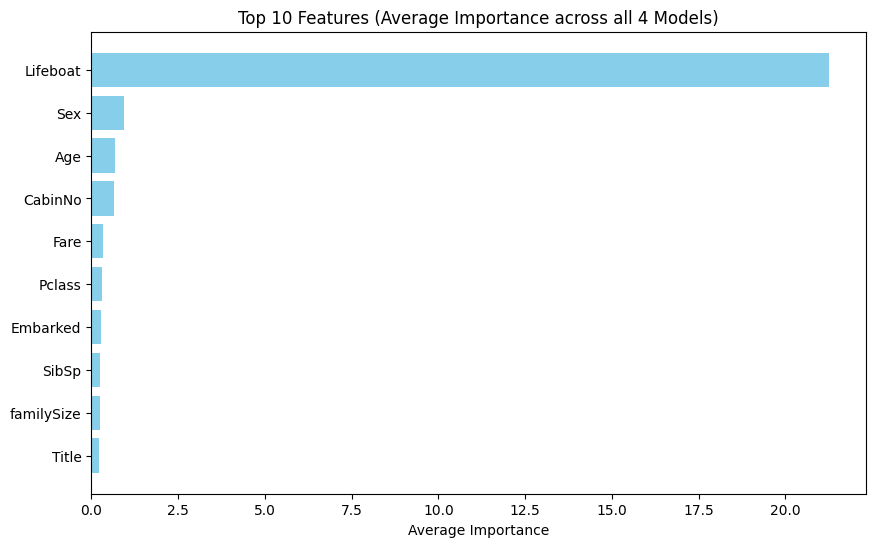

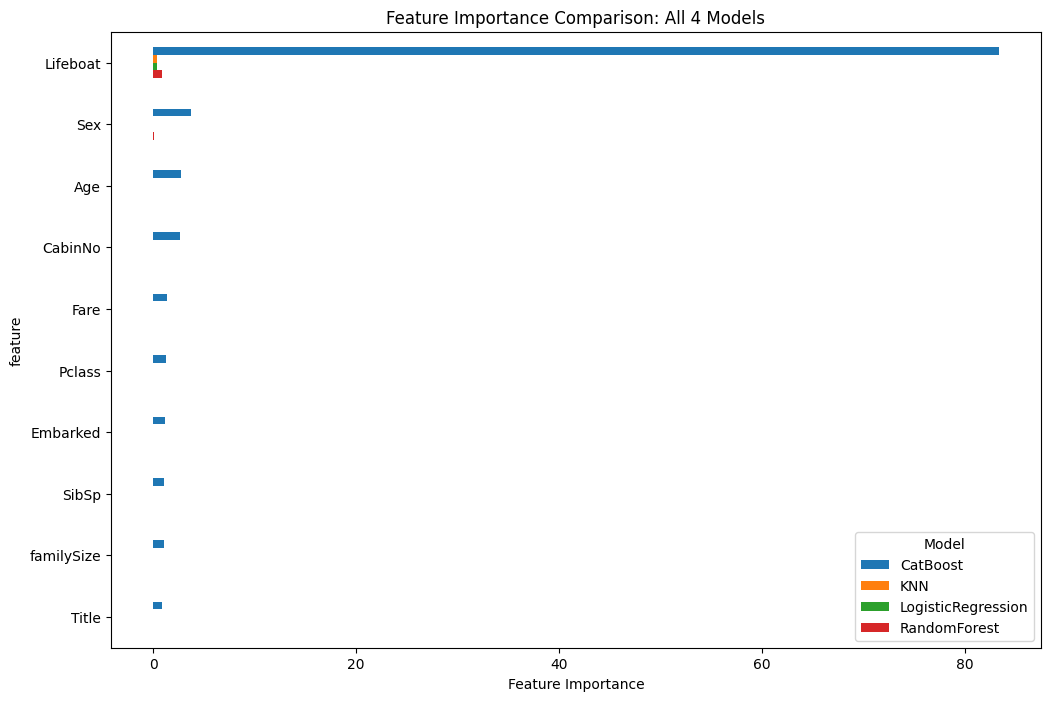

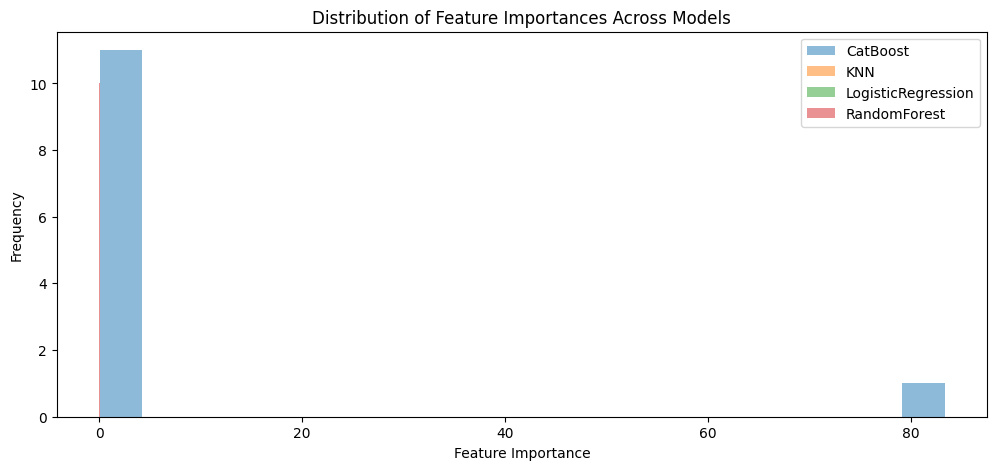

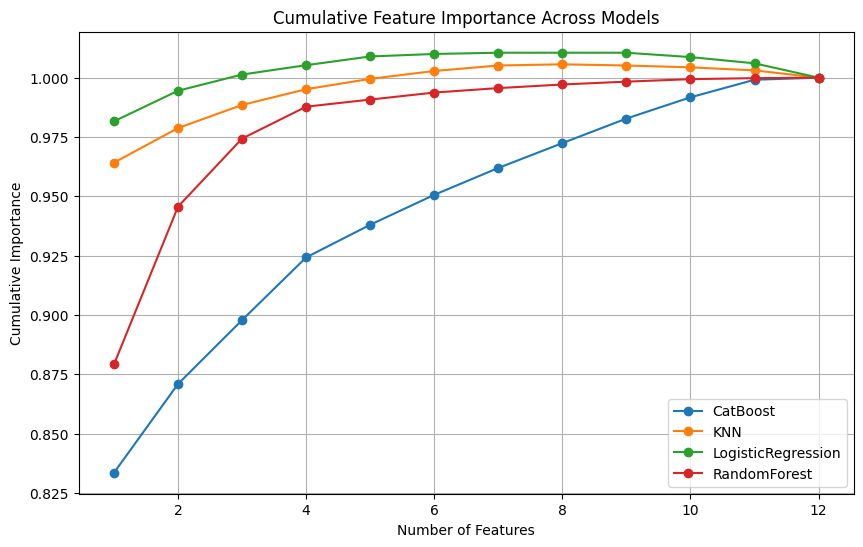

In [15]:
from sklearn.inspection import permutation_importance

# --- Function to get feature importance ---
def get_feature_importance(model, x, y, model_name="Model"):
    """
    Returns a DataFrame of feature importances for both tree-based and non-tree models.
    Tree models: CatBoost, RandomForest
    Non-tree models: Logistic Regression, KNN using permutation importance
    """
    fi = None
    if model_name.lower() == "catboost":
        fi_raw = model.get_feature_importance(prettified=True)
        fi = pd.DataFrame({'feature': fi_raw['Feature Id'], 'importance': fi_raw['Importances']})
    elif model_name.lower() == "randomforest":
        fi = pd.DataFrame({'feature': x.columns, 'importance': model.feature_importances_})
    else:  # permutation importance for non-tree models
        result = permutation_importance(model, x, y, n_repeats=10, random_state=42, scoring='accuracy')
        fi = pd.DataFrame({'feature': x.columns, 'importance': result.importances_mean})
    
    fi['model'] = model_name
    return fi

# --- Fit all models ---
clf1.fit(x, y)  # CatBoost
clf2.fit(x, y)  # KNN
clf3.fit(x, y)  # Logistic Regression
clf4.fit(x, y)  # Random Forest

# --- Collect feature importances ---
feature_importances = []
feature_importances.append(get_feature_importance(clf1, x, y, "CatBoost"))
feature_importances.append(get_feature_importance(clf2, x, y, "KNN"))
feature_importances.append(get_feature_importance(clf3, x, y, "LogisticRegression"))
feature_importances.append(get_feature_importance(clf4, x, y, "RandomForest"))

# --- Combine all models ---
fi_all = pd.concat(feature_importances).sort_values('importance', ascending=False)

# --- Top 10 features by average importance ---
top_features = fi_all.groupby('feature')['importance'].mean().sort_values(ascending=False).head(10)
print("Top 10 Features (Average Importance across all models):")
print(top_features)

# --- Visualization 1: Horizontal bar plot ---
plt.figure(figsize=(10,6))
plt.barh(top_features.index[::-1], top_features.values[::-1], color='skyblue')
plt.xlabel("Average Importance")
plt.title("Top 10 Features (Average Importance across all 4 Models)")
plt.show()

# --- Visualization 2: Comparison across models ---
fi_pivot = fi_all.pivot(index='feature', columns='model', values='importance').fillna(0)
fi_pivot_top = fi_pivot.loc[top_features.index]

fi_pivot_top.plot(kind='barh', figsize=(12,8))
plt.xlabel("Feature Importance")
plt.title("Feature Importance Comparison: All 4 Models")
plt.gca().invert_yaxis()
plt.legend(title='Model')
plt.show()

# --- Visualization 3: Importance Distribution ---
plt.figure(figsize=(12,5))
for model_name, fi in zip(['CatBoost','KNN','LogisticRegression','RandomForest'], feature_importances):
    plt.hist(fi['importance'], bins=20, alpha=0.5, label=model_name)
plt.xlabel("Feature Importance")
plt.ylabel("Frequency")
plt.title("Distribution of Feature Importances Across Models")
plt.legend()
plt.show()

# --- Visualization 4: Cumulative Importance ---
plt.figure(figsize=(10,6))
for model_name, fi in zip(['CatBoost','KNN','LogisticRegression','RandomForest'], feature_importances):
    sorted_fi = fi.sort_values('importance', ascending=False)
    cum_importance = sorted_fi['importance'].cumsum() / sorted_fi['importance'].sum()
    plt.plot(range(1,len(cum_importance)+1), cum_importance, marker='o', label=model_name)

plt.xlabel("Number of Features")
plt.ylabel("Cumulative Importance")
plt.title("Cumulative Feature Importance Across Models")
plt.grid(True)
plt.legend()
plt.show()


Average Importance Across Models:
 feature
Lifeboat      21.268896
Sex            0.952330
Age            0.674767
CabinNo        0.661662
Fare           0.344214
Pclass         0.318288
Embarked       0.284337
SibSp          0.261995
familySize     0.259701
Title          0.232806
Name: importance, dtype: float64

Consensus Feature Importance (Top 10):
          average_importance  top_model_count
Lifeboat           21.268896                4
Sex                 0.952330                3
Age                 0.674767                3
Title               0.232806                3
CabinNo             0.661662                2
Fare                0.344214                2
Pclass              0.318288                1
Embarked            0.284337                1
Parch               0.185571                1
SibSp               0.261995                0


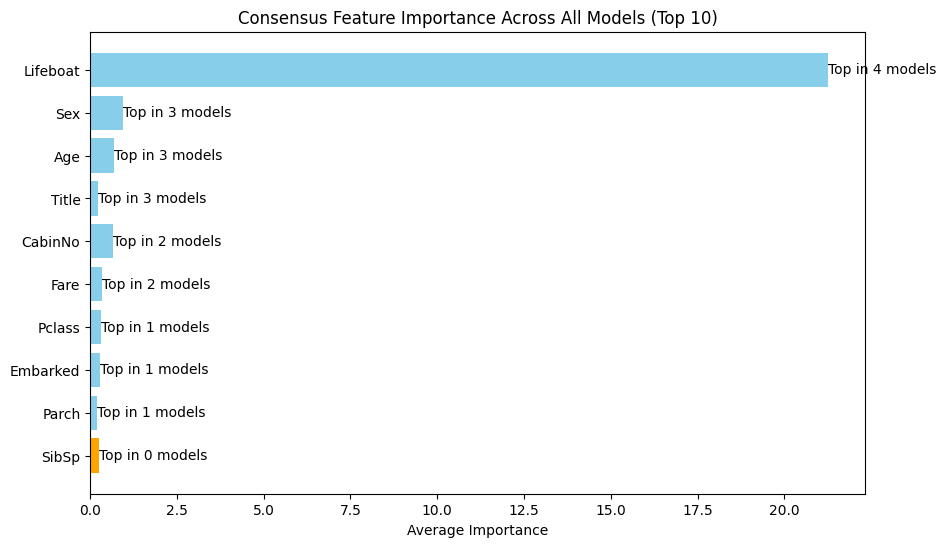

In [16]:
# --- Consensus Feature Importance ---

# 1. Average importance across all models
fi_avg = fi_all.groupby('feature')['importance'].mean().sort_values(ascending=False)
print("Average Importance Across Models:\n", fi_avg.head(10))

# 2. Count how many models rank this feature in their top 5
top_count = {}
for feature in fi_avg.index:
    count = 0
    for fi in feature_importances:
        if feature in fi.sort_values('importance', ascending=False).head(5)['feature'].values:
            count += 1
    top_count[feature] = count

consensus_df = pd.DataFrame({
    'average_importance': fi_avg,
    'top_model_count': pd.Series(top_count)
})

# Sort by top_model_count first, then average importance
consensus_df = consensus_df.sort_values(by=['top_model_count', 'average_importance'], ascending=False)
print("\nConsensus Feature Importance (Top 10):")
print(consensus_df.head(10))

# --- Visualization: Consensus Top Features ---
plt.figure(figsize=(10,6))
colors = ['skyblue' if x < 4 else 'orange' for x in consensus_df['top_model_count']]
plt.barh(consensus_df.head(10).index[::-1], consensus_df.head(10)['average_importance'][::-1], color=colors)
for i, val in enumerate(consensus_df.head(10)['top_model_count'][::-1]):
    plt.text(consensus_df.head(10)['average_importance'][::-1].iloc[i]+0.001, i, f"Top in {val} models", va='center')
plt.xlabel("Average Importance")
plt.title("Consensus Feature Importance Across All Models (Top 10)")
plt.show()


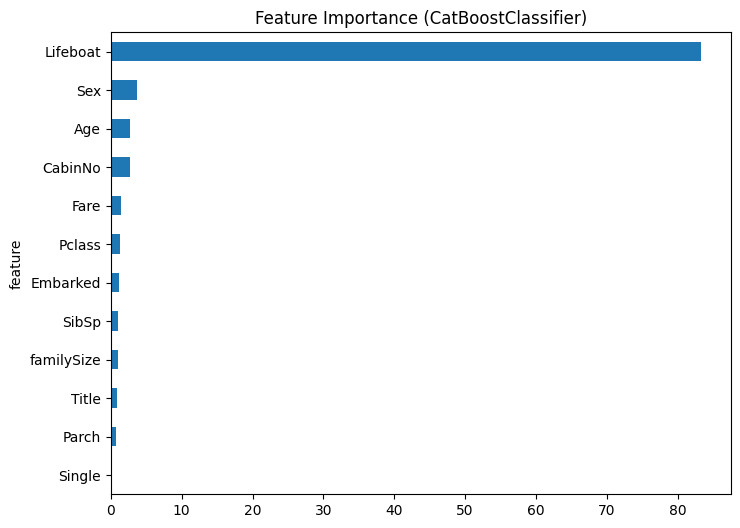

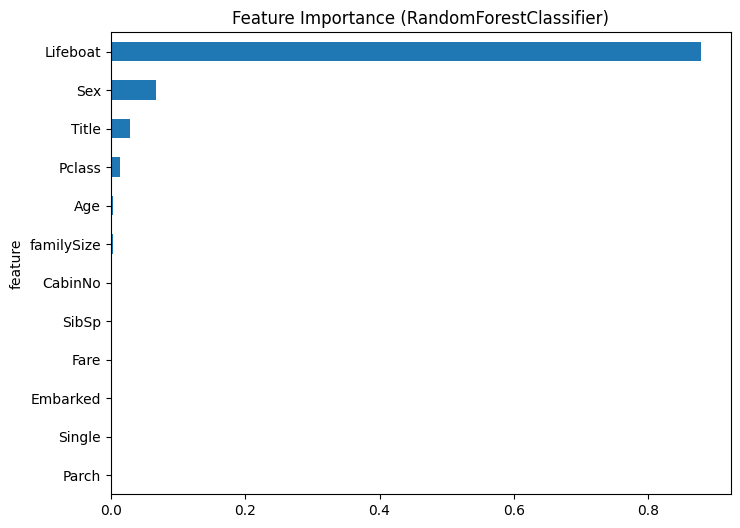

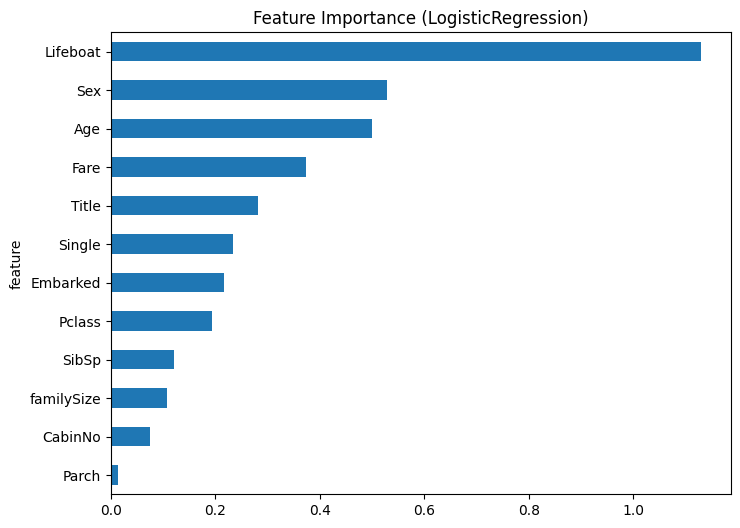

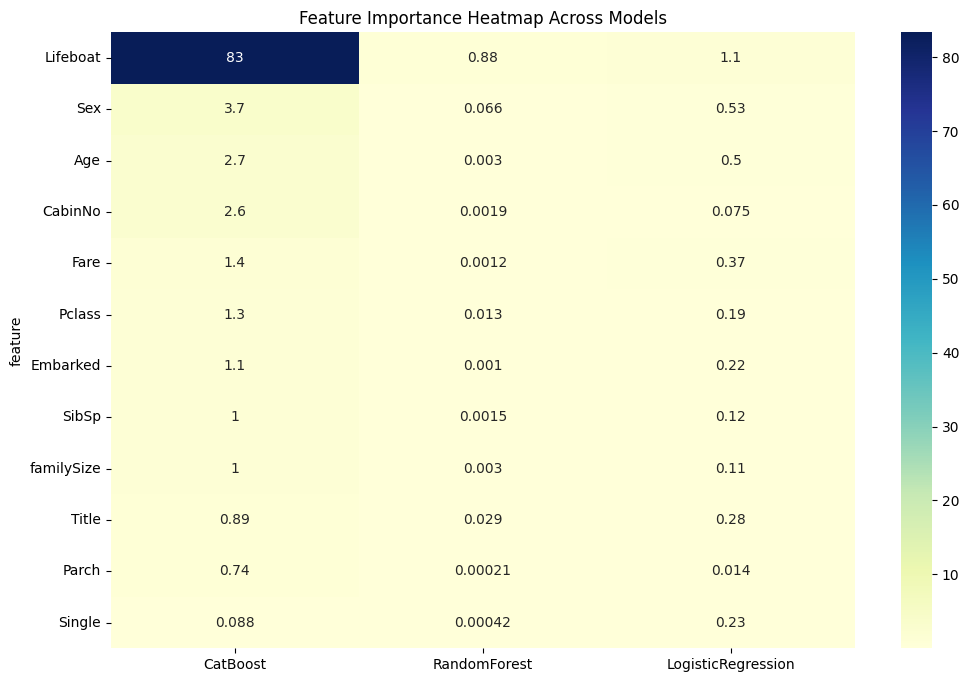

In [17]:
# --- Feature Importance Function ---
def get_feature_importance(df, exclude, target, model, no_features_in_plot=20):
    """
    Get feature importance for tree-based or linear models
    df: dataframe with target column
    exclude: list of columns to exclude
    target: target column name
    model: fitted model (CatBoost, RandomForest, LogisticRegression)
    no_features_in_plot: number of top features to plot
    """
    X = df.drop(columns=exclude + [target], errors='ignore')
    y = df[target]

    # Fit the model if not already fitted
    model.fit(X, y)

    # Get importance
    if hasattr(model, 'feature_importances_'):  # tree-based
        importance = model.feature_importances_
    elif hasattr(model, 'coef_'):  # linear
        importance = np.abs(model.coef_).flatten()
    else:
        raise ValueError("Model type not supported for feature importance")

    fi = pd.DataFrame({
        'feature': X.columns,
        'importance': importance
    }).sort_values(by='importance', ascending=False).reset_index(drop=True)

    # Plot top features
    fi[:no_features_in_plot].plot.barh(x='feature', y='importance', figsize=(8,6), legend=False)
    plt.gca().invert_yaxis()
    plt.title(f'Feature Importance ({type(model).__name__})')
    plt.show()

    return fi

# --- Calculate Feature Importances ---
feature_importances = {}

feature_importances['CatBoost'] = get_feature_importance(alldata, exclude=[], target='Survived', model=clf1)
feature_importances['RandomForest'] = get_feature_importance(alldata, exclude=[], target='Survived', model=clf4)
feature_importances['LogisticRegression'] = get_feature_importance(alldata, exclude=[], target='Survived', model=clf3)

# --- Combine into Heatmap ---
import seaborn as sns

# Prepare heatmap dataframe
fi_heatmap = pd.DataFrame()
for model_name, fi in feature_importances.items():
    fi_temp = fi.set_index('feature')['importance']
    fi_heatmap[model_name] = fi_temp

# Fill missing features with 0
fi_heatmap = fi_heatmap.fillna(0)

plt.figure(figsize=(12,8))
sns.heatmap(fi_heatmap, annot=True, cmap="YlGnBu")
plt.title('Feature Importance Heatmap Across Models')
plt.show()
